In [2]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%tensorflow_version 2.x 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import json
from glob import glob
from PIL import Image
import pickle
import keras
import warnings

import sys, time, os, warnings 

from tqdm import tqdm

from collections import Counter 
from nltk.translate.bleu_score import sentence_bleu

import seaborn as sns

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/MyDrive/DLProject')

In [8]:
!unzip Images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844747252_64567cf14a.jpg  
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b57211

In [9]:
images_path = '/content/drive/MyDrive/DLProject/Images/'
captions_path = '/content/drive/MyDrive/DLProject/Flickr8k.token.txt'

total_images = os.listdir(images_path)
print("Total Number of images: {}".format(len(total_images)))

Total Number of images: 8091


In [10]:
file = open(captions_path, 'r')
text = file.read()
file.close()

rows = text.split('\n')
data = []
for row in rows:
    if row:
        file_caption = row.split('\t')
        if len(file_caption) == 1:
          continue
        filename_index = file_caption[0]
        index_list = filename_index.split('#')
        data.append((index_list[0], index_list[1], file_caption[1]))

images_data = pd.DataFrame(data, columns=['filename', 'index', 'captions'])
print(images_data.head())

unique_files = np.unique(images_data.filename.values)
print("Total images : {}".format(len(unique_files)))
Counter(Counter(images_data.filename.values).values())

                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                            captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
Total images : 8091


Counter({5: 8091})

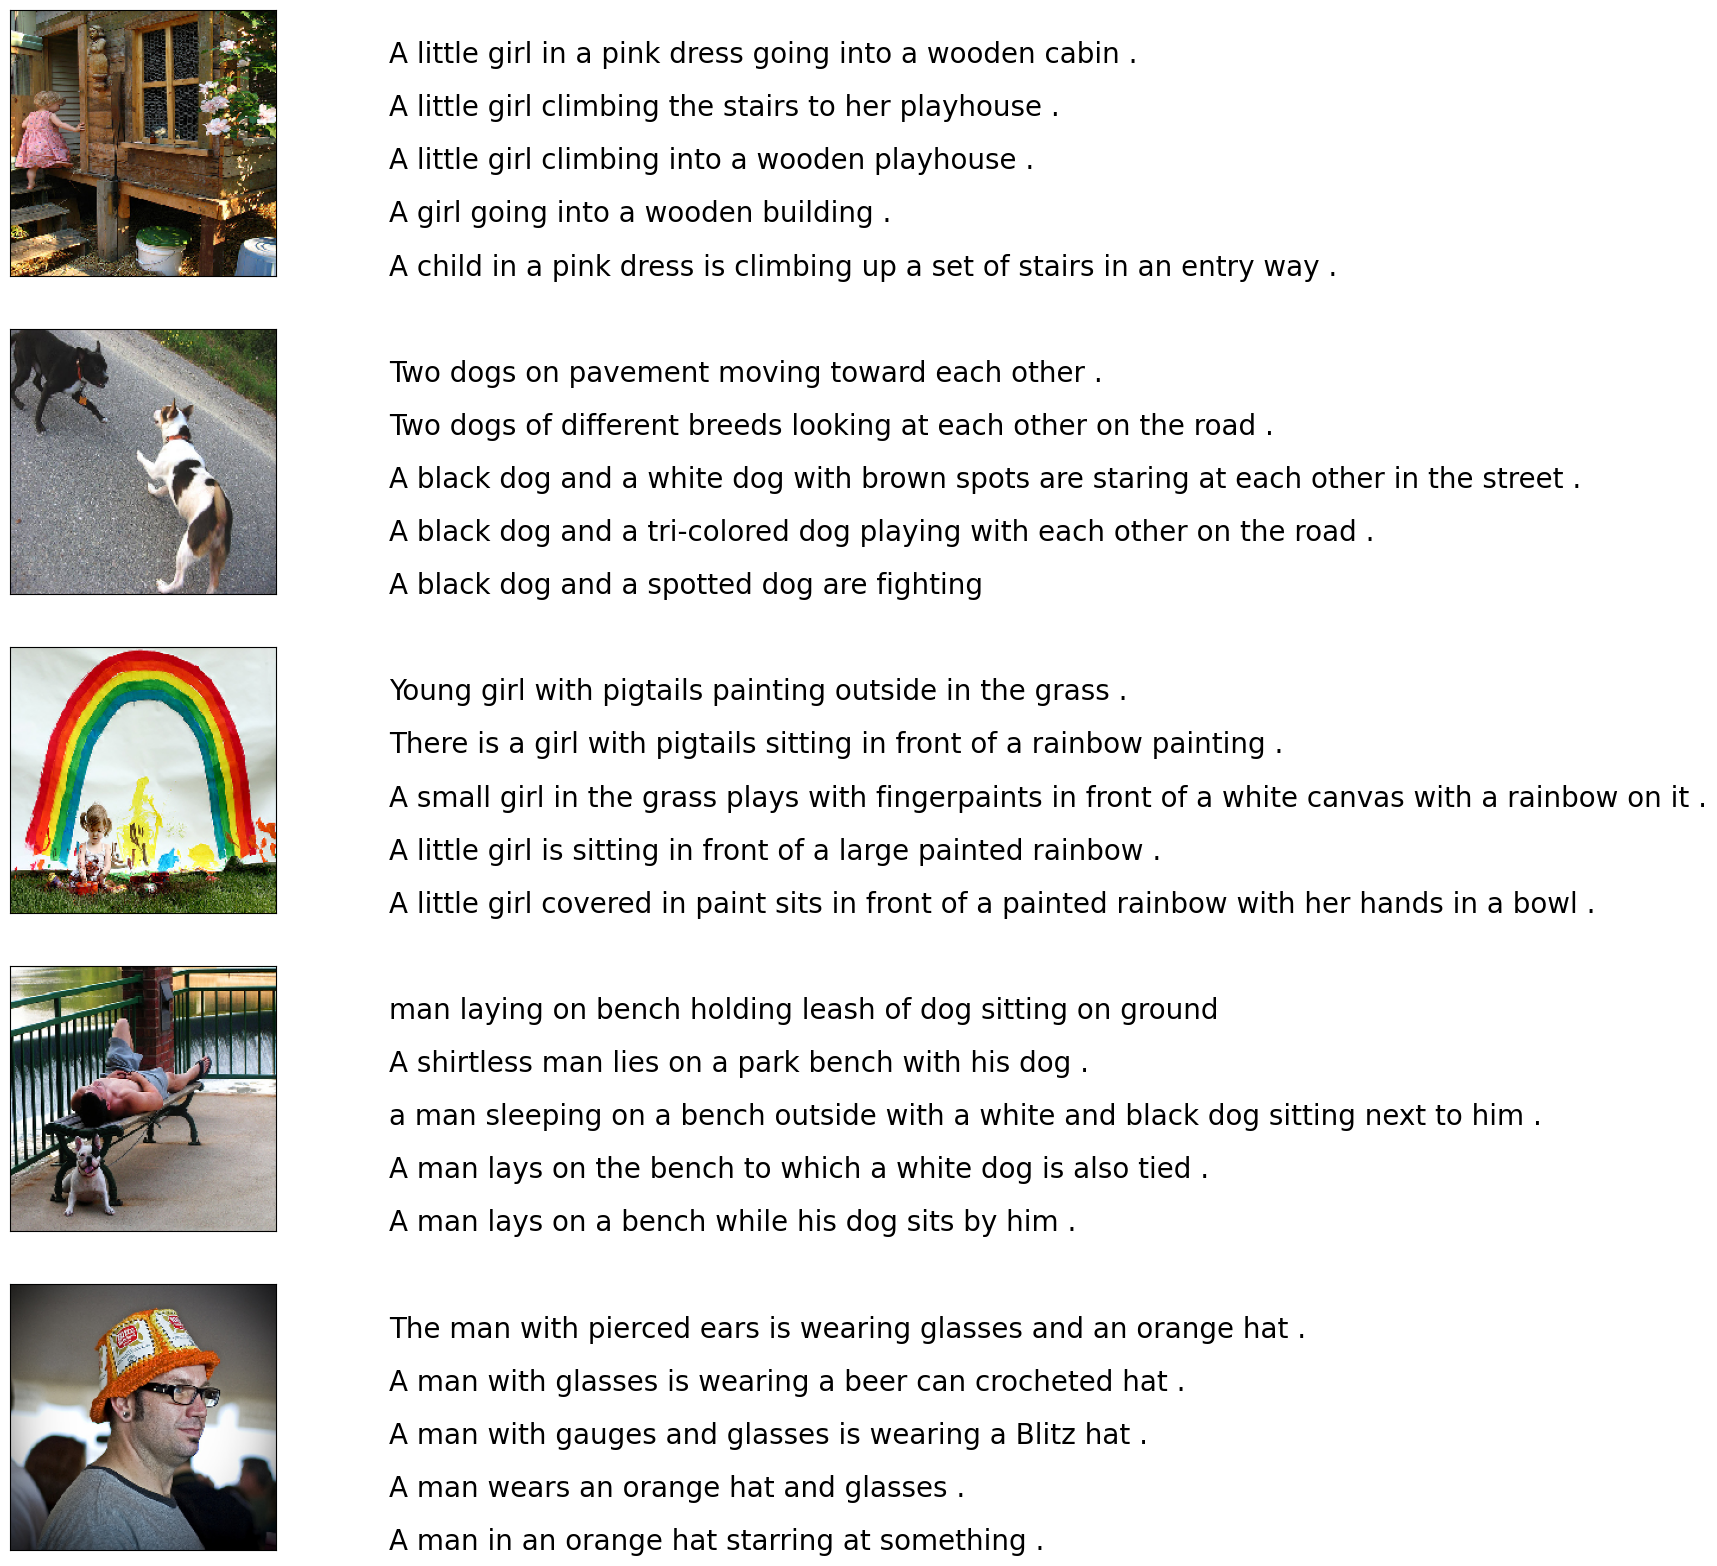

In [11]:
pic = 5
pixel = 224
target_size = (pixel,pixel,3)

count = 1
fig = plt.figure(figsize=(10,20))
for fl in unique_files[:pic]:
    filename = images_path + '/' + fl
    captions = list(images_data["captions"].loc[images_data["filename"]==fl].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(pic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(pic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [12]:
def vocabulary(df_txt):
  vocab = []
  for txt in df_txt.captions.values:
    vocab.extend(txt.split())
  print('Total words in vocabulary: %d' % len(set(vocab)))
  ct = Counter(vocab)
  word_data = pd.DataFrame.from_dict(ct, orient='index').sort_values(by=0, ascending=False)
  word_data = word_data.reset_index()
  word_data = word_data.rename({'index':'word',0:'count'}, axis=1)
  return(word_data)

word_data = vocabulary(images_data)
word_data.head()

Total words in vocabulary: 9630


word  count
0    a  40319
1    .  36577
2    A  22667
3   in  18962
4  the  15328

In [13]:
images = images_data['filename'].tolist()
captions = images_data['captions'].tolist()

img_list = list()
for name in images:
  full_path = images_path + name
  img_list.append(full_path)

cap_list = list()
for caption in captions:
  new_caption = '<start> ' + caption + ' <end>'
  cap_list.append(new_caption)

train_captions_, img_vector_ = shuffle(cap_list,
                                          img_list,
                                          random_state=1)


num_examples = 35900
train_captions = train_captions_[:num_examples]
img_name_vector = img_vector_[:num_examples]

print("img_name_vector", img_name_vector[:10])
print("train_captions", train_captions[:10])

test_captions = train_captions_[num_examples:]
fnm_test = img_vector_[num_examples:]

print("Training with ",len(train_captions), "captions in total of:", len(cap_list))

img_name_vector ['/content/drive/MyDrive/DLProject/Images/1956678973_223cb1b847.jpg', '/content/drive/MyDrive/DLProject/Images/3256603992_67312b5a36.jpg', '/content/drive/MyDrive/DLProject/Images/2938747424_64e64784f0.jpg', '/content/drive/MyDrive/DLProject/Images/2831314869_5025300133.jpg', '/content/drive/MyDrive/DLProject/Images/516725192_c9cdd63878.jpg', '/content/drive/MyDrive/DLProject/Images/537559285_29be110134.jpg', '/content/drive/MyDrive/DLProject/Images/2172493537_128bc8b187.jpg', '/content/drive/MyDrive/DLProject/Images/2287023569_fd7a9c60b8.jpg', '/content/drive/MyDrive/DLProject/Images/3191805046_77c334b506.jpg', '/content/drive/MyDrive/DLProject/Images/2869491449_1041485a6b.jpg']
train_captions ['<start> Several children leaping into a pile of leaves on the ground . <end>', '<start> A man hiking in the wilderness giving the camera a thumbs up . <end>', '<start> A white dog is running through the water onto the shore . <end>', '<start> a young man relaxing his legs on a 

In [14]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    image_path += '/'
    return img, image_path

In [15]:
cnn = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = cnn.input
hidden_layer = cnn.layers[-1].output

feature_extractor = tf.keras.Model(new_input, hidden_layer)

feature_extractor.summary()

87910968/87910968 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

In [16]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = feature_extractor(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    base_path, ext = path_of_feature.split('.')
    np.save(base_path, bf.numpy())

100%|██████████| 506/506 [03:21<00:00,  2.51it/s]


In [17]:
def maximum_length(tensor):
    return max(len(t) for t in tensor)
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
sequences = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [18]:
sequences = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')

max_length = maximum_length(sequences)

In [19]:
train_data, test_data, train_captions, test_captions = train_test_split(img_name_vector, cap_vector, test_size=0.2, random_state=0)

len(train_data), len(train_captions), len(test_data), len(test_captions)

(28720, 28720, 7180, 7180)

In [20]:
train_data, val_data, train_captions, val_captions = train_test_split(img_name_vector, cap_vector, test_size=0.1, random_state=0)

len(train_data), len(train_captions), len(val_data), len(val_captions)

(32310, 32310, 3590, 3590)

In [21]:
def load_numpy(img_name, cap):
  base_path = img_name.decode('utf-8').split(".")
  img_tensor = np.load(base_path[0]+'.npy')
  return img_tensor, cap

bs = 64
buffer = 1000
dimension = 256
units = 512
vocab_size = top_k + 1
num_steps = len(train_data) // bs

features_shape = 2048
attention_features_shape = 64

ds = tf.data.Dataset.from_tensor_slices((train_data, train_captions))

ds = ds.map(lambda item1, item2: tf.numpy_function(
          load_numpy, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds = ds.shuffle(buffer).batch(bs)
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_captions))

val_ds = val_ds.map(lambda item1, item2: tf.numpy_function(
          load_numpy, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.shuffle(buffer).batch(bs)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
class SoftAttention(tf.keras.Model):
  def __init__(self, units):
    super(SoftAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    def __init__(self, dimension):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(dimension)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, dimension, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, dimension)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = SoftAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, bs):
    return tf.zeros((bs, self.units))

In [23]:
encoder = CNN_Encoder(dimension)
decoder = RNN_Decoder(dimension, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [24]:
checkpoint_path = "./checkpoints/train"
check = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
start_epoch = 0
manage_checkpoint = tf.train.CheckpointManager(check, checkpoint_path, max_to_keep=5)
if manage_checkpoint.latest_checkpoint:
  start_epoch = int(manage_checkpoint.latest_checkpoint.split('-')[-1])
  check.restore(manage_checkpoint.latest_checkpoint)

In [25]:
@tf.function
def training(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(bs=target.shape[0])
  d_ip = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(d_ip, features, hidden)

          loss += loss_function(target[:, i], predictions)

          d_ip = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [26]:
for k, v in enumerate(ds):
  print(k, v)

Streaming output truncated to the last 5000 lines.
        [0.        , 0.        , 0.        , ..., 0.74549925,
         0.6313831 , 1.1938875 ],
        [0.        , 0.        , 0.        , ..., 0.48666352,
         0.19680406, 1.3617538 ],
        [0.4741647 , 0.        , 0.        , ..., 0.01993426,
         0.05981204, 1.7049148 ]],

       [[0.        , 0.        , 0.        , ..., 0.25511283,
         0.        , 0.        ],
        [0.        , 0.        , 0.14546973, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.34593254, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 2.0047743 , 0.        , ..., 0.        ,
         0.        , 0.9875858 ],
        [0.        , 1.41054   , 0.16516091, ..., 0.        ,
         0.        , 0.24308032],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.   

In [27]:
for k, v in enumerate(val_ds):
  print(k, v)

Streaming output truncated to the last 5000 lines.
         3.93318594e-01, 2.49710009e-01, 4.80406761e-01],
        [0.00000000e+00, 2.40715683e-01, 0.00000000e+00, ...,
         4.72461991e-02, 3.72842222e-01, 5.73333263e-01],
        [0.00000000e+00, 7.62849152e-01, 6.38509244e-02, ...,
         0.00000000e+00, 4.83574867e-01, 4.70846653e-01]],

       ...,

       [[0.00000000e+00, 0.00000000e+00, 1.58870652e-01, ...,
         5.53498626e-01, 2.30855402e-02, 5.13183653e-01],
        [0.00000000e+00, 0.00000000e+00, 5.83066404e-01, ...,
         1.32924557e+00, 2.06498459e-01, 1.12055218e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.80272269e+00, 1.40997279e+00, 2.51924109e+00],
        ...,
        [7.67649055e-01, 0.00000000e+00, 7.07646191e-01, ...,
         1.81622374e+00, 0.00000000e+00, 9.66972172e-01],
        [3.48734975e+00, 0.00000000e+00, 2.19507337e+00, ...,
         6.64975524e-01, 0.00000000e+00, 1.13739705e+00],
        [2.04645681e+00

In [28]:
loss_plot = []
val_loss_plot = []
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    val_total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(ds):
        batch_loss, t_loss = training(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    for (batch, (img_tensor, target)) in enumerate(val_ds):
        val_batch_loss, val_t_loss = training(img_tensor, target)
        val_total_loss += val_t_loss
        if batch % 100 == 0:
            print('Val_Loss {:.4f}'.format(val_batch_loss.numpy() / int(target.shape[1])))
    val_loss_plot.append(val_total_loss / num_steps)

    if epoch % 5 == 0:
      manage_checkpoint.save()

    print ('Epoch {} Loss {:.6f} Val_Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, val_total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7744
Epoch 1 Batch 100 Loss 1.4760
Epoch 1 Batch 200 Loss 1.4902
Epoch 1 Batch 300 Loss 1.3081
Epoch 1 Batch 400 Loss 1.2179
Epoch 1 Batch 500 Loss 1.2120
Val_Loss 1.1640
Epoch 1 Loss 1.355221 Val_Loss 0.123969
Time taken for 1 epoch 194.11809968948364 sec

Epoch 2 Batch 0 Loss 1.0713
Epoch 2 Batch 100 Loss 1.0791
Epoch 2 Batch 200 Loss 1.0826
Epoch 2 Batch 300 Loss 0.9694
Epoch 2 Batch 400 Loss 0.9240
Epoch 2 Batch 500 Loss 0.9303
Val_Loss 0.9242
Epoch 2 Loss 1.016448 Val_Loss 0.107122
Time taken for 1 epoch 69.48990607261658 sec

Epoch 3 Batch 0 Loss 0.9743
Epoch 3 Batch 100 Loss 1.0606
Epoch 3 Batch 200 Loss 1.0151
Epoch 3 Batch 300 Loss 0.8361
Epoch 3 Batch 400 Loss 0.9462
Epoch 3 Batch 500 Loss 0.8586
Val_Loss 0.8445
Epoch 3 Loss 0.911497 Val_Loss 0.097948
Time taken for 1 epoch 68.12254428863525 sec

Epoch 4 Batch 0 Loss 0.9948
Epoch 4 Batch 100 Loss 0.7794
Epoch 4 Batch 200 Loss 0.8514
Epoch 4 Batch 300 Loss 0.8856
Epoch 4 Batch 400 Loss 0.9053
Epoch 4 Bat

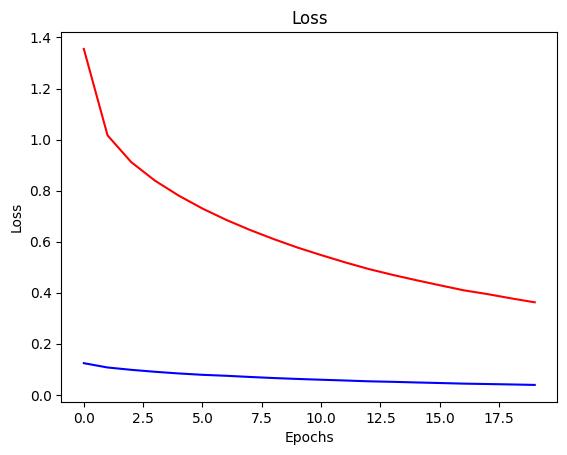

In [29]:
plt.plot(loss_plot, color='red')
plt.plot(val_loss_plot, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [30]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(bs=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_extractor(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a man on a red bicycle rides past several pedestrians <end>
Prediction Caption: a cyclist biking gear rides bike on their bike past a bike as a race biker <end>


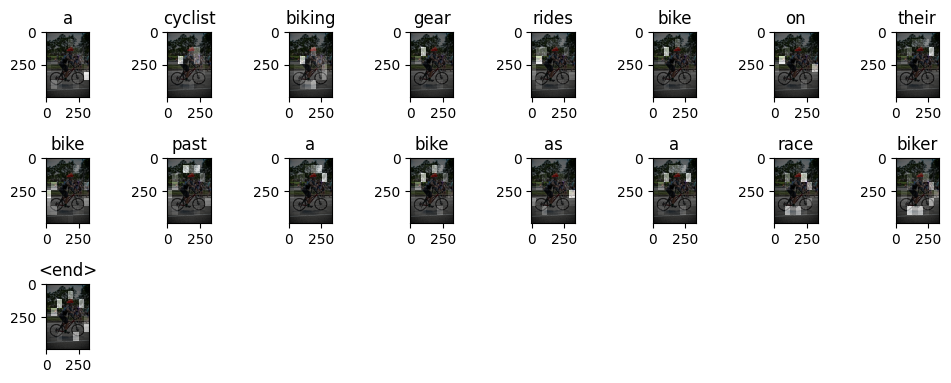

In [31]:
rid = np.random.randint(0, len(val_data))
image = val_data[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in val_captions[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [32]:
real_captions = []
generated_captions = []
img_path = []

n_tests = 300

for i,image in enumerate(test_data[:n_tests]):
  real_captions.append(' '.join([tokenizer.index_word[i] for i in test_captions[i] if i not in [0]]))
  caption, attention_plot = evaluate(image)
  img_path.append(image)
  generated_captions.append(caption)
  if i % 100 == 0: print("Describing id %d" %(i)) 

Describing id 0
Describing id 100
Describing id 200


			 BLEU
BLEU higher:  1.0
BLEU lower:  0.0
Mean BLEU Score 0.105


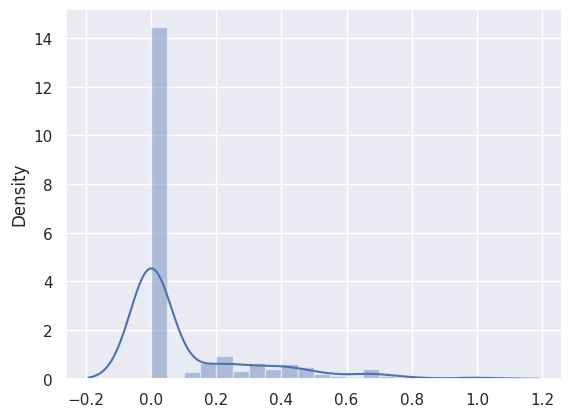

In [33]:
warnings.filterwarnings('ignore')
tokenized_real_captions = []
tokenized_generated_captions = []
for caption in generated_captions:
  d_caption = caption[:len(caption)-1]
  tokenized_generated_captions.append(d_caption)

for caption in real_captions:
  back_caption = caption
  back_caption = back_caption.split()
  back_caption = back_caption[1:-1]
  tokenized_real_captions.append(back_caption)

pred_good, pred_bad, bleus, meteors = [], [], [], []
for i, path in enumerate(img_path):
  caption_true = tokenized_real_captions[i]
  gen_caption = tokenized_generated_captions[i]
  bleu = sentence_bleu([caption_true], gen_caption)
  bleus.append(bleu)
  if bleu > 0.7:
    pred_good.append((bleu,path,caption_true,gen_caption))
  elif bleu < 0.3:
    pred_bad.append((bleu,path,caption_true,gen_caption))

sns.set(color_codes = True)
sns.distplot(bleus)

print("\t\t\t BLEU")
print("BLEU higher: ", np.amax(bleus))
print("BLEU lower: ", np.amin(bleus))
print("Mean BLEU Score {:4.3f}".format(np.mean(bleus)))

Bad Captions


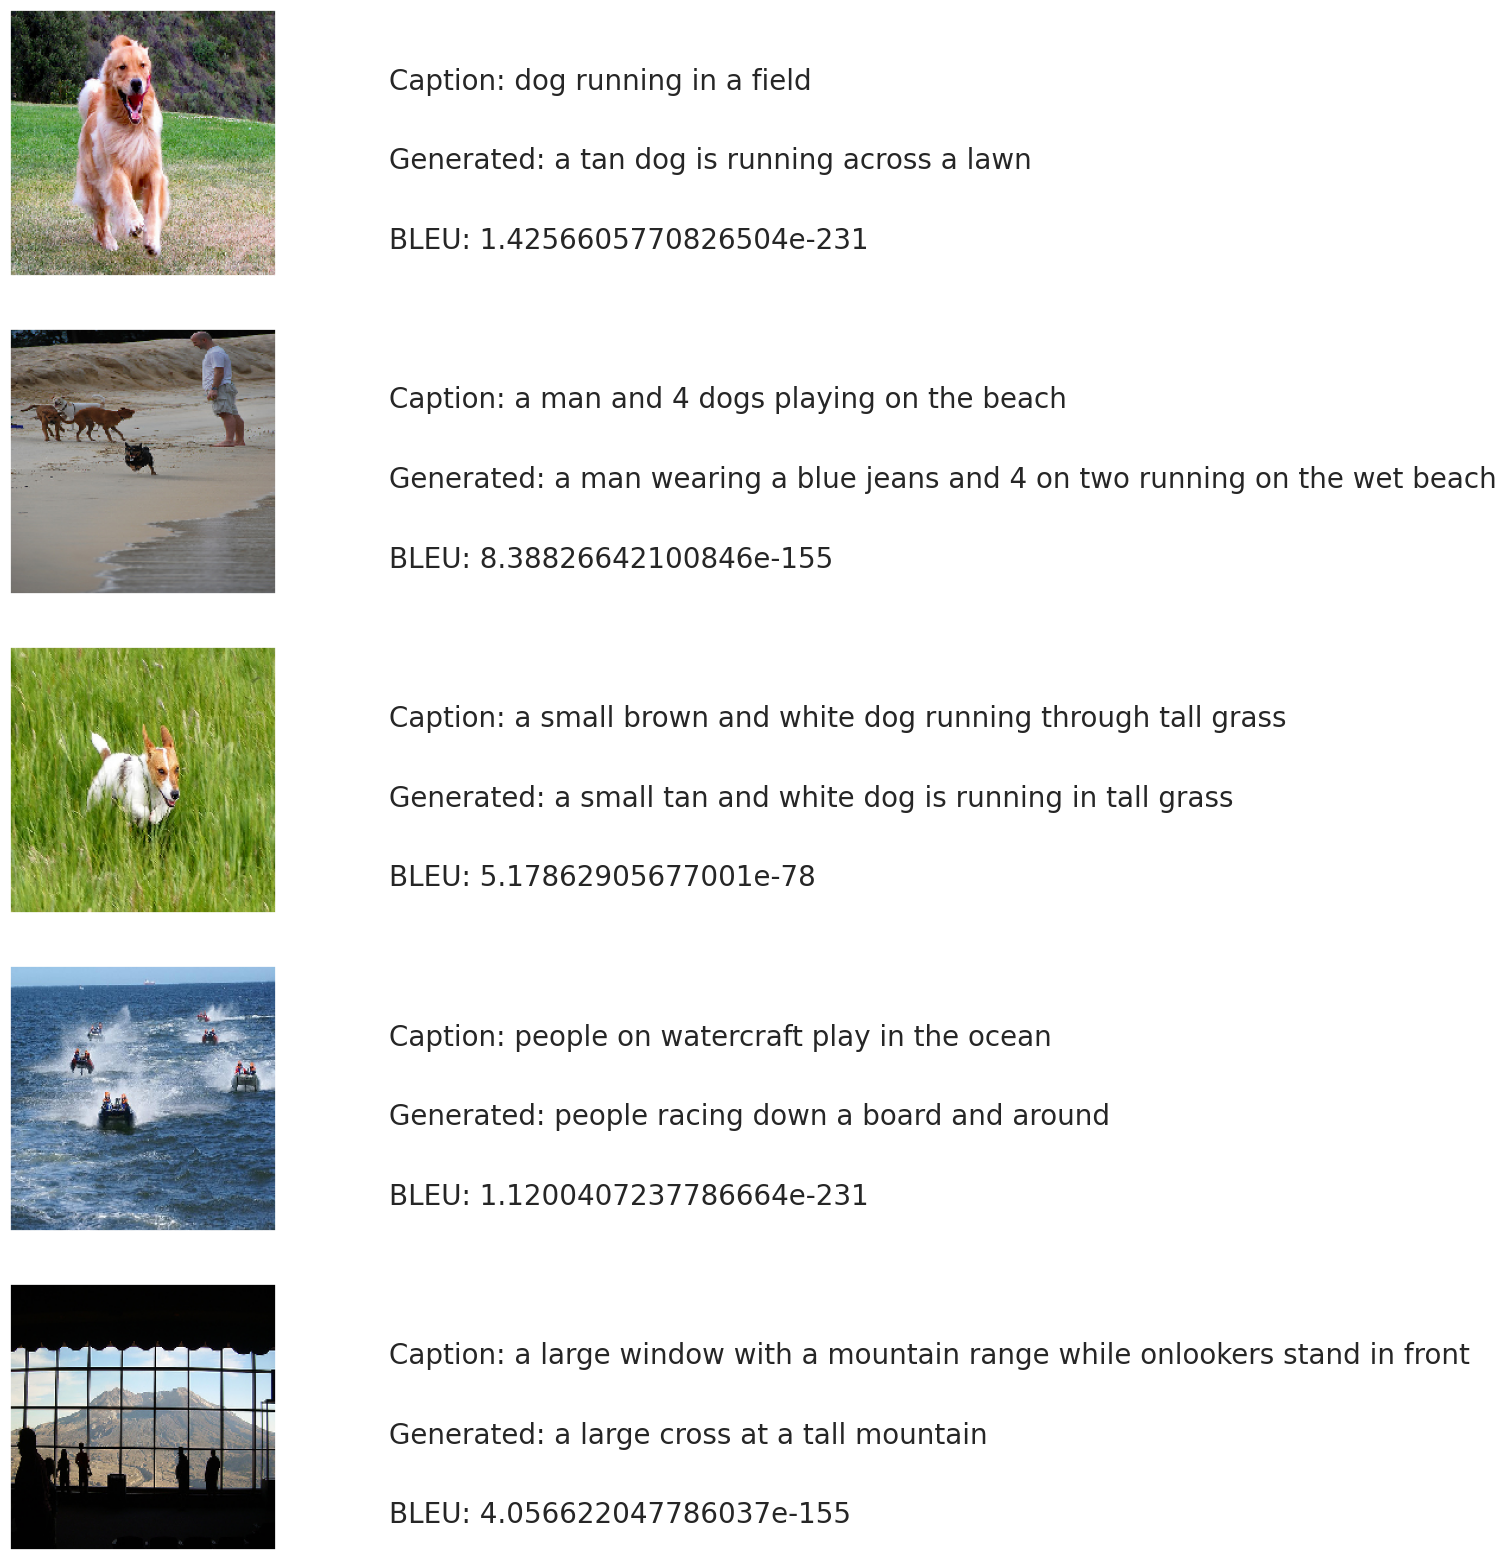

Good Captions


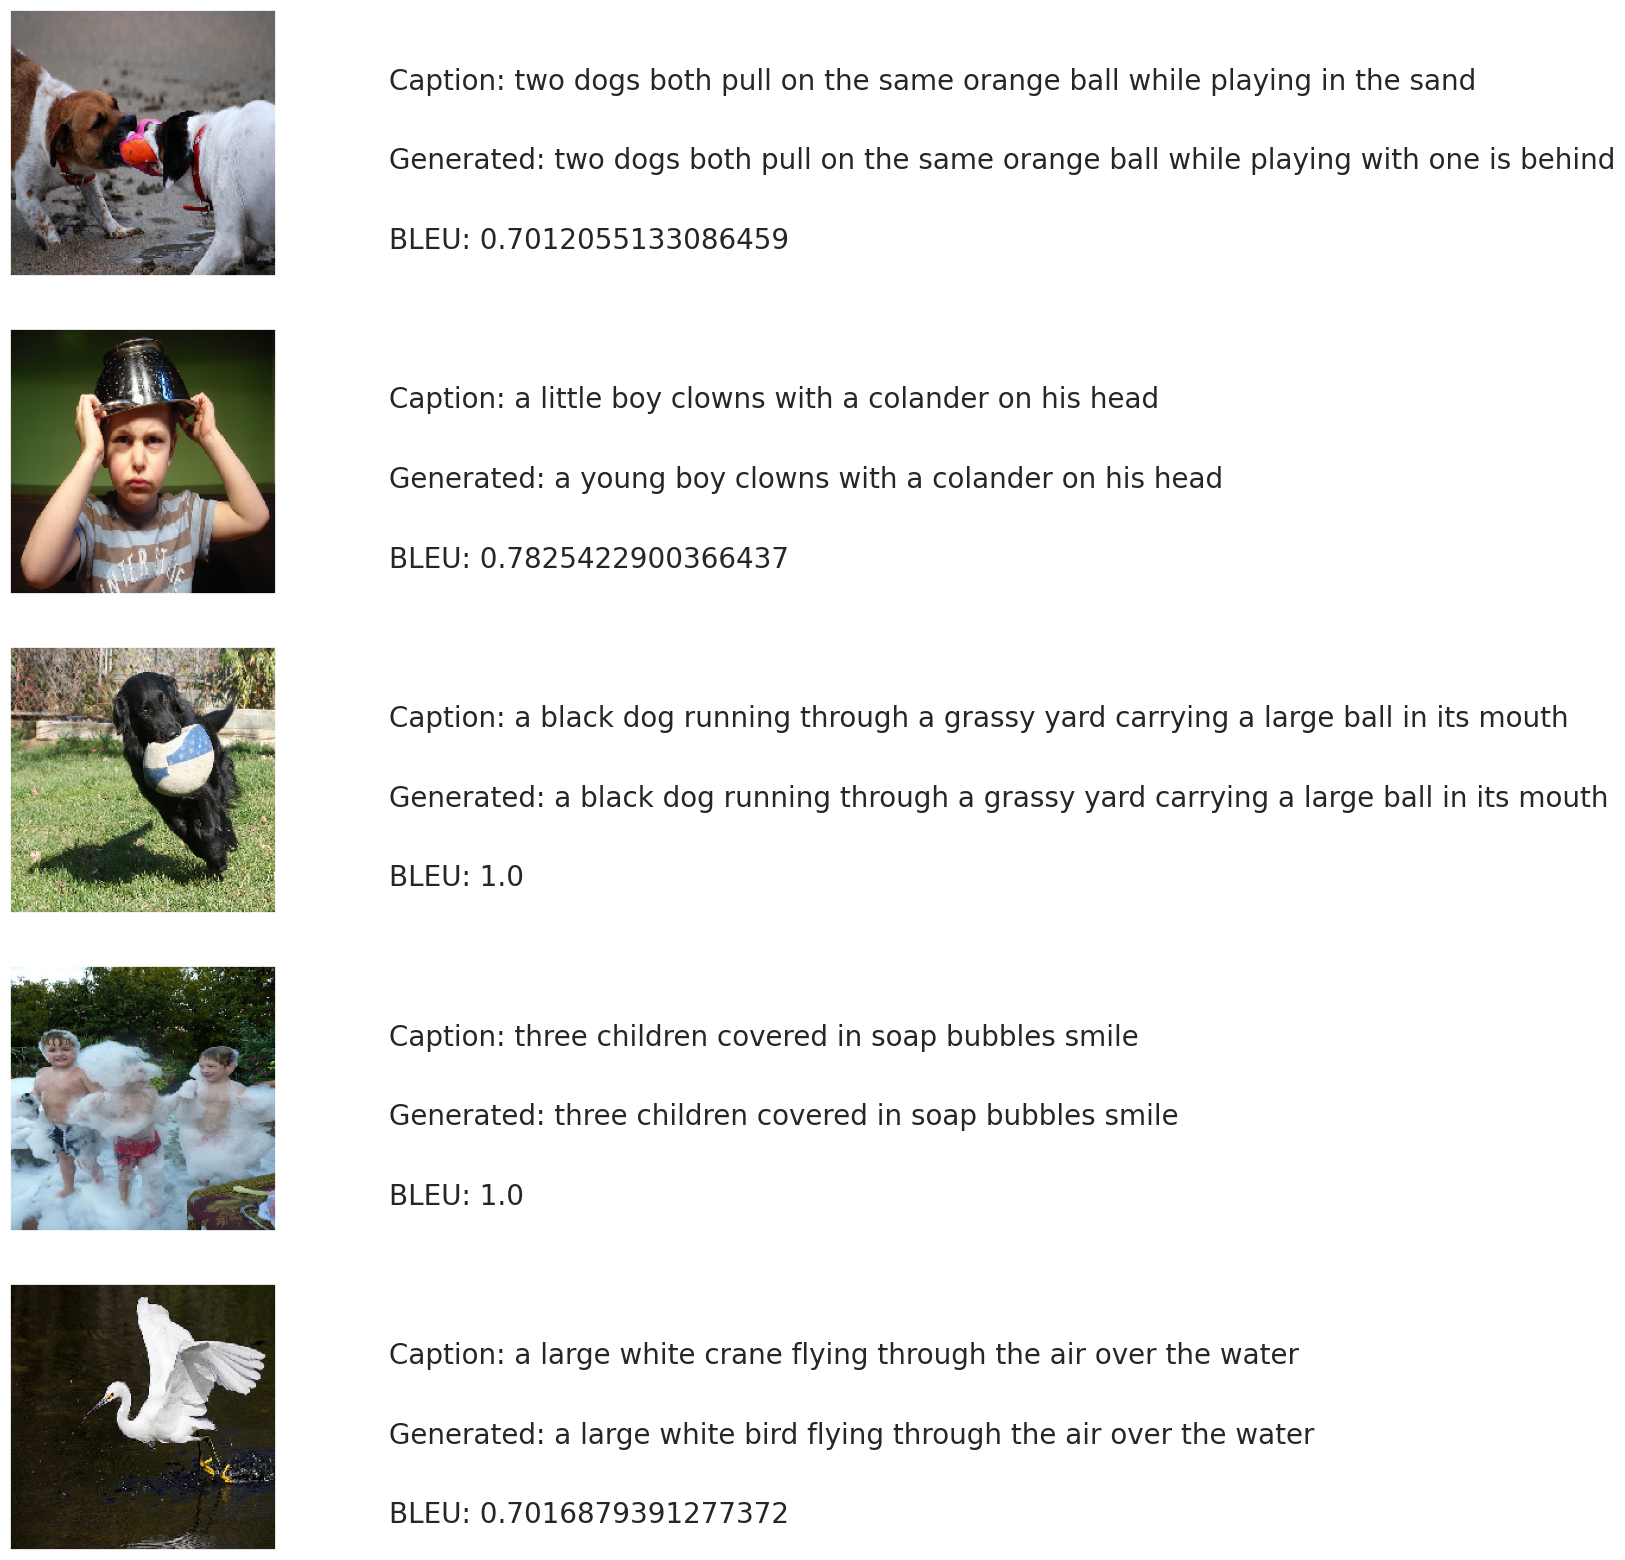

In [34]:
def plot_images(generated_captions):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(generated_captions)
    for pb in generated_captions:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"Caption:" + caption_true,fontsize=20)
        ax.text(0,0.4,"Generated:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Captions")
plot_images(pred_bad[:5])
print("Good Captions")
plot_images(pred_good[:5])

Base Model

In [43]:
class Base_CNN_Encoder(tf.keras.Model):
    def __init__(self, dimension):
        super(Base_CNN_Encoder, self).__init__()
        self.cnn = tf.keras.applications.InceptionV3(include_top=False,
                                                     weights='imagenet')
        self.cnn.trainable = False
        self.reshape = tf.keras.layers.Reshape((64, 2048))

    def call(self, x):
        x = self.cnn(x)
        x = self.reshape(x)
        return x

class Base_RNN_Decoder(tf.keras.Model):
    def __init__(self, dimension, units, vocab_size):
        super(Base_RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, dimension)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):
        x = self.embedding(x)
        x = tf.concat([features, x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)

        return x, state

    def reset_state(self, bs):
        return tf.zeros((bs, self.units))




In [44]:
dimension = 256

base_encoder = Base_CNN_Encoder(dimension)
base_decoder = Base_RNN_Decoder(dimension, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


In [37]:
@tf.function
def base_training(img_tensor, target):
  loss = 0
  hidden = base_decoder.reset_state(bs=target.shape[0])
  d_ip = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = base_encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = base_decoder(d_ip, features, hidden)

          loss += loss_function(target[:, i], predictions)

          d_ip = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = base_encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [38]:
loss_plot = []
val_loss_plot = []
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    val_total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(ds):
        batch_loss, t_loss = training(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    for (batch, (img_tensor, target)) in enumerate(val_ds):
        val_batch_loss, val_t_loss = training(img_tensor, target)
        val_total_loss += val_t_loss
        if batch % 100 == 0:
            print('Val_Loss {:.4f}'.format(val_batch_loss.numpy() / int(target.shape[1])))
    val_loss_plot.append(val_total_loss / num_steps)

    if epoch % 5 == 0:
      manage_checkpoint.save()

    print ('Epoch {} Loss {:.6f} Val_Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, val_total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.4176
Epoch 1 Batch 100 Loss 0.3346
Epoch 1 Batch 200 Loss 0.3465
Epoch 1 Batch 300 Loss 0.3184
Epoch 1 Batch 400 Loss 0.3671
Epoch 1 Batch 500 Loss 0.3276
Val_Loss 0.3598
Epoch 1 Loss 0.349595 Val_Loss 0.037891
Time taken for 1 epoch 68.22345662117004 sec

Epoch 2 Batch 0 Loss 0.3841
Epoch 2 Batch 100 Loss 0.3159
Epoch 2 Batch 200 Loss 0.3377
Epoch 2 Batch 300 Loss 0.3428
Epoch 2 Batch 400 Loss 0.3386
Epoch 2 Batch 500 Loss 0.3295
Val_Loss 0.3975
Epoch 2 Loss 0.337396 Val_Loss 0.035956
Time taken for 1 epoch 66.64205074310303 sec

Epoch 3 Batch 0 Loss 0.3547
Epoch 3 Batch 100 Loss 0.3820
Epoch 3 Batch 200 Loss 0.3154
Epoch 3 Batch 300 Loss 0.3073
Epoch 3 Batch 400 Loss 0.3433
Epoch 3 Batch 500 Loss 0.3075
Val_Loss 0.3429
Epoch 3 Loss 0.328172 Val_Loss 0.034498
Time taken for 1 epoch 66.29605841636658 sec

Epoch 4 Batch 0 Loss 0.4079
Epoch 4 Batch 100 Loss 0.3074
Epoch 4 Batch 200 Loss 0.2902
Epoch 4 Batch 300 Loss 0.3293
Epoch 4 Batch 400 Loss 0.3115
Epoch 4 Batc

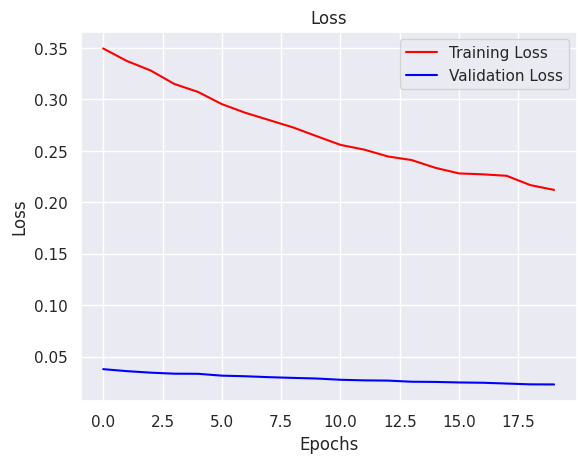

In [39]:
plt.plot(loss_plot, color='red', label='Training Loss')
plt.plot(val_loss_plot, color='blue', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [45]:
def evaluate_basemodel(image):

    hidden = base_decoder.reset_state(bs=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = base_encoder(temp_input)

    features = feature_extractor(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden = base_decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result
